## An effort to apply a Generative Adversarial Network (GAN) model to CIFAR-10 dataset.

In [1]:
from matplotlib import pyplot
import numpy as np
import cv2
from tensorflow import keras
cifar10 = keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

shape = train_images.shape[0], train_images.shape[1], train_images.shape[2], train_images.shape[3]

(50000, 32, 32, 3)

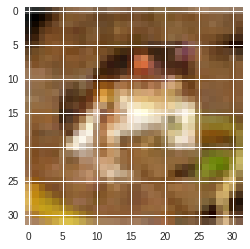

In [4]:
pyplot.imshow(train_images[0])
pyplot.xticks([])
pyplot.yticks([])
train_images.shape

In [4]:
def _preprocess(train_images):         #To reduce the size of each channel to (28, 28)
    
    train_images = train_images/127.5-1.
    img_list = []
    for i in range(train_images.shape[0]):
        
        img = cv2.resize(train_images[i], (28,28))
        img_list.append(img)
        
    img_list = np.array(img_list)
        
    return img_list     

In [5]:
import tensorflow as tf

def model_inputs(image_width, image_height, image_channels, z_dim):

    inputs_real = tf.placeholder(tf.float32, shape=(None, 28, 28, 3), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

In [6]:
def discriminator(images, reuse=False):

    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # 4 layer network
        
        # Conv 1
        conv1 = tf.layers.conv2d(images, 64, 5, 2, 'SAME')
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        
        # Conv 2
        conv2 = tf.layers.conv2d(lrelu1, 128, 5, 2, 'SAME')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # Conv 3
        conv3 = tf.layers.conv2d(lrelu2, 256, 5, 1, 'SAME')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
       
        # Flatten
        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        
        # Logits
        logits = tf.layers.dense(flat, 1)
        
        # Output
        out = tf.sigmoid(logits)
        
        return out, logits

In [7]:
def generator(z, out_channel_dim, is_train=True):

    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        # First fully connected layer
        x_1 = tf.layers.dense(z, 2*2*512)
        
        # Reshape it to start the convolutional stack
        deconv_2 = tf.reshape(x_1, (-1, 2, 2, 512))
        batch_norm2 = tf.layers.batch_normalization(deconv_2, training=is_train)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # Deconv 1
        deconv3 = tf.layers.conv2d_transpose(lrelu2, 256, 5, 2, padding='VALID')
        batch_norm3 = tf.layers.batch_normalization(deconv3, training=is_train)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        
        # Deconv 2
        deconv4 = tf.layers.conv2d_transpose(lrelu3, 128, 5, 2, padding='SAME')
        batch_norm4 = tf.layers.batch_normalization(deconv4, training=is_train)
        lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 5, 2, padding='SAME')
        
        out = tf.tanh(logits)
        
        return out

In [8]:
def model_loss(input_real, input_z, out_channel_dim):

    
    label_smoothing = 0.9 #To help the discriminator generalize better, 
                          #the labels are reduced a bit from 1.0 to 0.9
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real) * label_smoothing))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
                                                  
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake) * label_smoothing))
    
    
    return d_loss, g_loss

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):

    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

In [10]:
def show_generator_output(sess, n_images, input_z, out_channel_dim):

    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})
    
    samples = (samples.reshape(28, 28, 3)+1)/2
    pyplot.imshow(samples)
    pyplot.xticks([])
    pyplot.yticks([])
    pyplot.show()

In [11]:
#Training 
def train(epoch_count, batch_size, z_dim, learning_rate, beta1,  data_shape):

    all_imgs=_preprocess(train_images)
    
    n_imgs = all_imgs.shape[0]
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    n_batches = n_imgs//batch_size
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            
            
            for idx in range(n_batches):
                
                
                batch_images = all_imgs[(idx)*batch_size:(idx+1)*batch_size]
                steps += 1
            
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if steps % 400 == 0:
                    
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    show_generator_output(sess, 1, input_z, data_shape[3])

Epoch 1/20... Discriminator Loss: 1.4326... Generator Loss: 0.6363


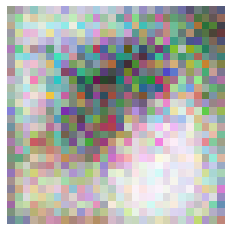

Epoch 1/20... Discriminator Loss: 1.1222... Generator Loss: 0.9355


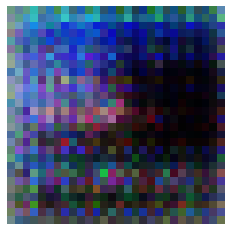

Epoch 1/20... Discriminator Loss: 1.2385... Generator Loss: 0.8318


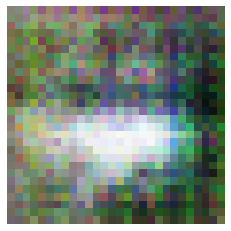

Epoch 1/20... Discriminator Loss: 1.2445... Generator Loss: 0.8410


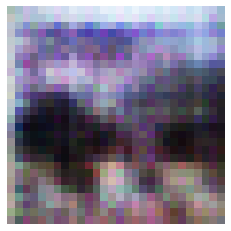

Epoch 1/20... Discriminator Loss: 1.2887... Generator Loss: 0.8375


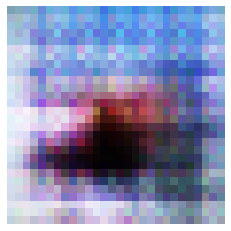

Epoch 1/20... Discriminator Loss: 1.2854... Generator Loss: 0.8593


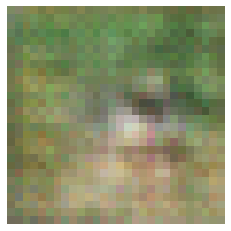

Epoch 1/20... Discriminator Loss: 1.2613... Generator Loss: 0.8096


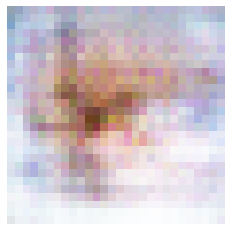

Epoch 2/20... Discriminator Loss: 1.5298... Generator Loss: 0.7141


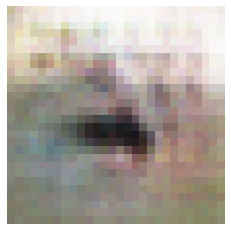

Epoch 2/20... Discriminator Loss: 1.2538... Generator Loss: 0.8064


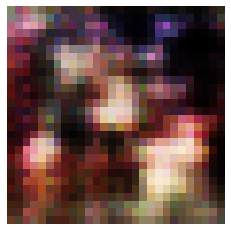

Epoch 2/20... Discriminator Loss: 1.2913... Generator Loss: 0.8280


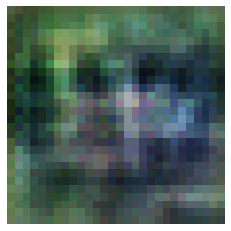

Epoch 2/20... Discriminator Loss: 1.2730... Generator Loss: 0.8124


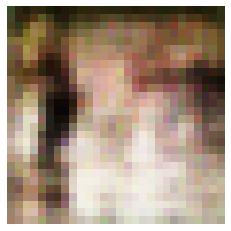

Epoch 2/20... Discriminator Loss: 1.3475... Generator Loss: 0.8472


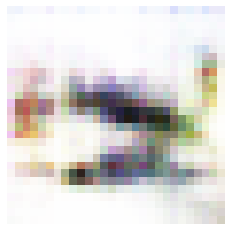

Epoch 2/20... Discriminator Loss: 1.2060... Generator Loss: 0.9155


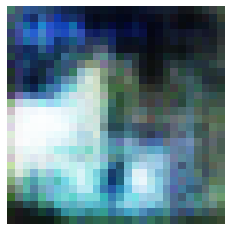

Epoch 2/20... Discriminator Loss: 1.3570... Generator Loss: 0.7881


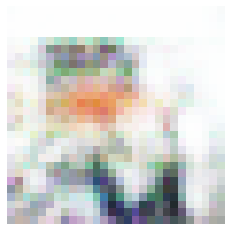

Epoch 2/20... Discriminator Loss: 1.2855... Generator Loss: 0.7853


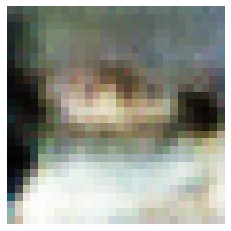

Epoch 3/20... Discriminator Loss: 1.0223... Generator Loss: 0.9427


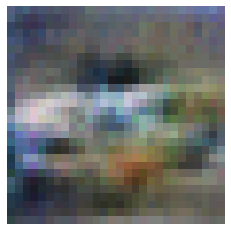

Epoch 3/20... Discriminator Loss: 1.2793... Generator Loss: 0.8200


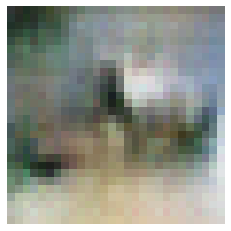

Epoch 3/20... Discriminator Loss: 1.4315... Generator Loss: 0.7046


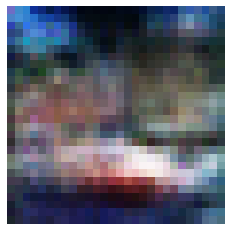

Epoch 3/20... Discriminator Loss: 1.2990... Generator Loss: 0.8035


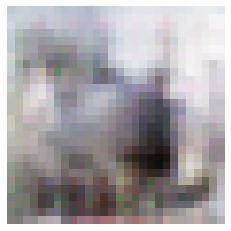

Epoch 3/20... Discriminator Loss: 1.3591... Generator Loss: 0.7844


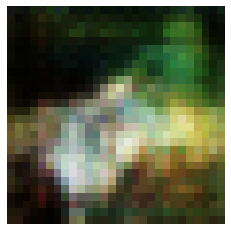

Epoch 3/20... Discriminator Loss: 1.2238... Generator Loss: 0.8188


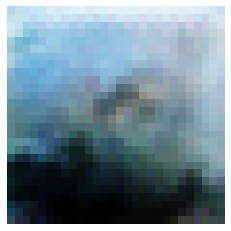

Epoch 3/20... Discriminator Loss: 1.2604... Generator Loss: 0.8205


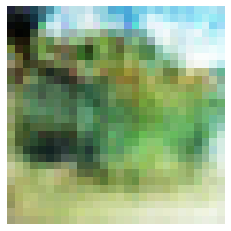

Epoch 3/20... Discriminator Loss: 1.0928... Generator Loss: 0.8977


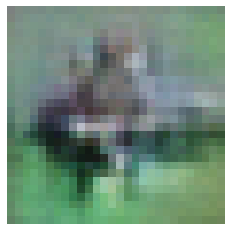

Epoch 4/20... Discriminator Loss: 1.3070... Generator Loss: 0.8039


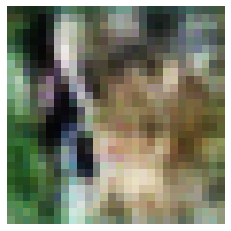

Epoch 4/20... Discriminator Loss: 1.0547... Generator Loss: 0.9268


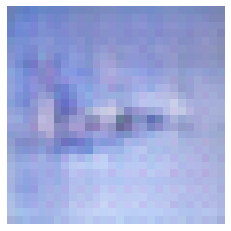

Epoch 4/20... Discriminator Loss: 1.1039... Generator Loss: 0.9394


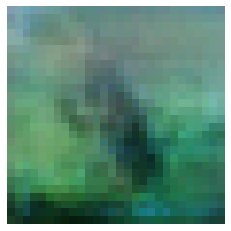

Epoch 4/20... Discriminator Loss: 1.2206... Generator Loss: 0.8541


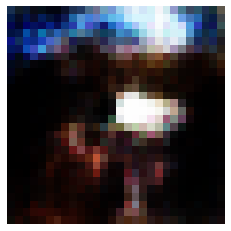

Epoch 4/20... Discriminator Loss: 0.9078... Generator Loss: 1.1587


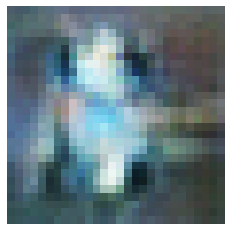

Epoch 4/20... Discriminator Loss: 1.4955... Generator Loss: 0.7647


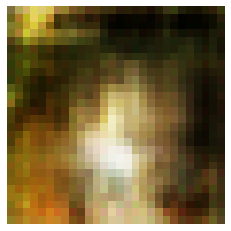

Epoch 4/20... Discriminator Loss: 1.1549... Generator Loss: 0.9517


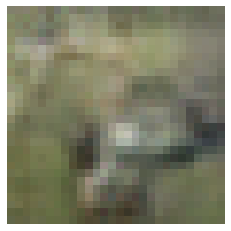

Epoch 4/20... Discriminator Loss: 0.9789... Generator Loss: 0.9838


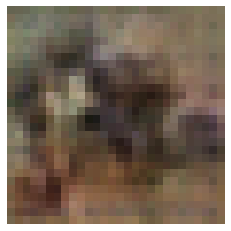

Epoch 5/20... Discriminator Loss: 1.0292... Generator Loss: 1.0282


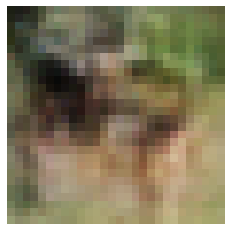

Epoch 5/20... Discriminator Loss: 1.0036... Generator Loss: 0.8133


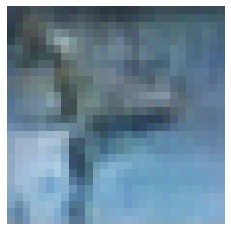

Epoch 5/20... Discriminator Loss: 0.9780... Generator Loss: 0.9918


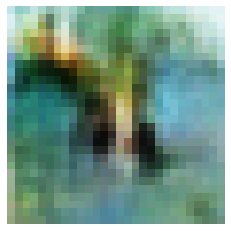

Epoch 5/20... Discriminator Loss: 1.0500... Generator Loss: 0.9842


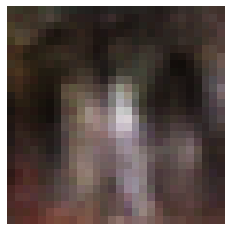

Epoch 5/20... Discriminator Loss: 0.9958... Generator Loss: 0.9103


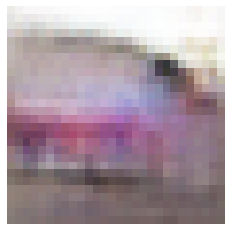

Epoch 5/20... Discriminator Loss: 0.9524... Generator Loss: 1.0168


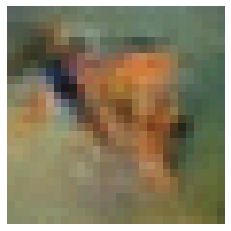

Epoch 5/20... Discriminator Loss: 0.8139... Generator Loss: 1.2392


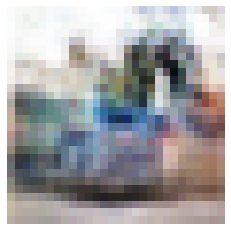

Epoch 5/20... Discriminator Loss: 0.9942... Generator Loss: 1.0718


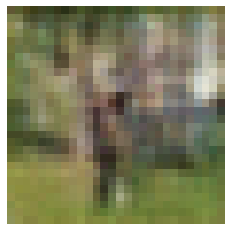

Epoch 6/20... Discriminator Loss: 1.0199... Generator Loss: 1.1539


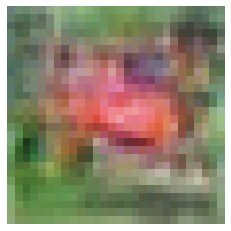

Epoch 6/20... Discriminator Loss: 1.3522... Generator Loss: 0.7741


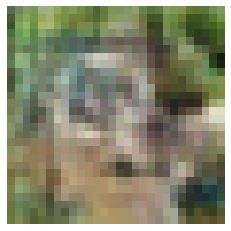

Epoch 6/20... Discriminator Loss: 0.9633... Generator Loss: 1.0777


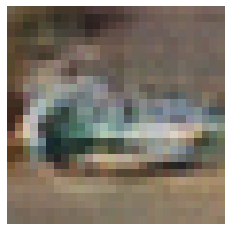

Epoch 6/20... Discriminator Loss: 1.3004... Generator Loss: 0.8765


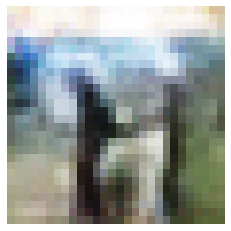

Epoch 6/20... Discriminator Loss: 0.9446... Generator Loss: 1.0614


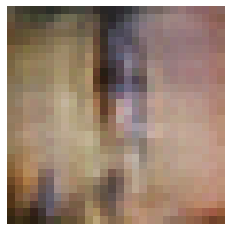

Epoch 6/20... Discriminator Loss: 1.1643... Generator Loss: 0.9123


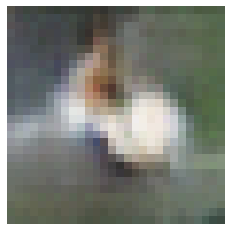

Epoch 6/20... Discriminator Loss: 1.1897... Generator Loss: 0.9066


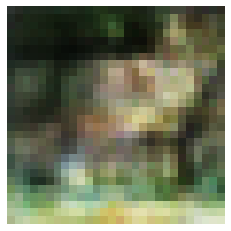

Epoch 7/20... Discriminator Loss: 0.6319... Generator Loss: 1.4193


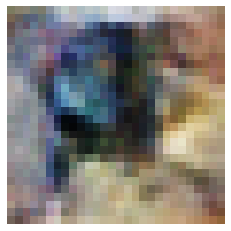

Epoch 7/20... Discriminator Loss: 0.9267... Generator Loss: 1.1673


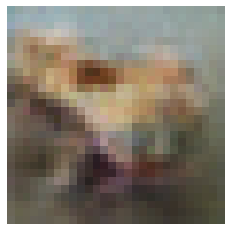

Epoch 7/20... Discriminator Loss: 1.0157... Generator Loss: 0.9482


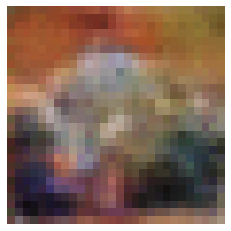

Epoch 7/20... Discriminator Loss: 1.2228... Generator Loss: 1.0133


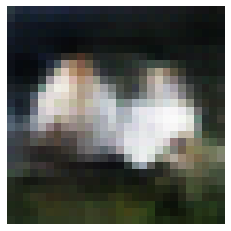

Epoch 7/20... Discriminator Loss: 0.9788... Generator Loss: 1.1076


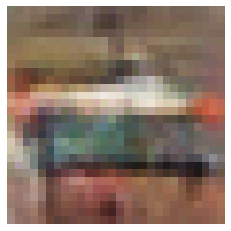

Epoch 7/20... Discriminator Loss: 1.0526... Generator Loss: 0.9887


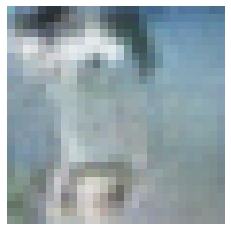

Epoch 7/20... Discriminator Loss: 1.0845... Generator Loss: 0.9156


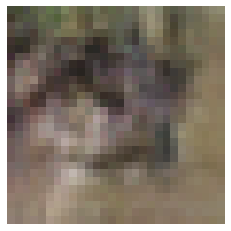

Epoch 7/20... Discriminator Loss: 1.0404... Generator Loss: 0.9963


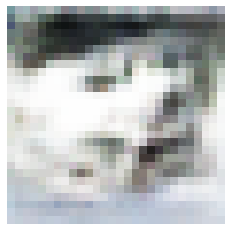

Epoch 8/20... Discriminator Loss: 1.1004... Generator Loss: 1.0627


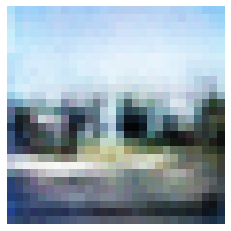

Epoch 8/20... Discriminator Loss: 1.2256... Generator Loss: 0.9009


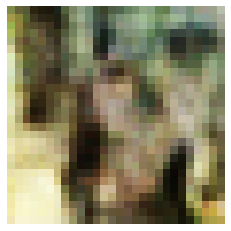

Epoch 8/20... Discriminator Loss: 0.9852... Generator Loss: 0.9313


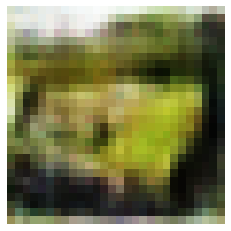

Epoch 8/20... Discriminator Loss: 0.8909... Generator Loss: 1.0422


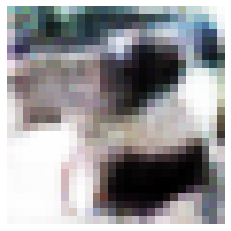

Epoch 8/20... Discriminator Loss: 0.9133... Generator Loss: 0.9507


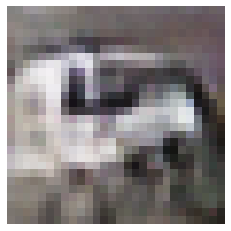

Epoch 8/20... Discriminator Loss: 0.9080... Generator Loss: 1.1094


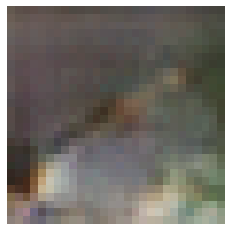

Epoch 8/20... Discriminator Loss: 0.9712... Generator Loss: 0.9224


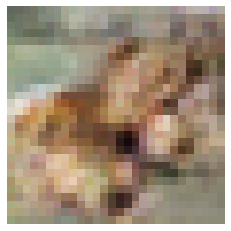

Epoch 8/20... Discriminator Loss: 0.9712... Generator Loss: 0.9068


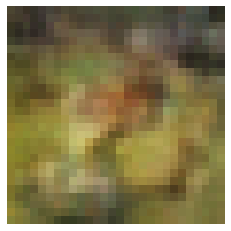

Epoch 9/20... Discriminator Loss: 0.7254... Generator Loss: 1.3881


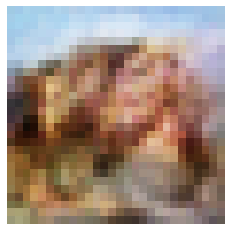

Epoch 9/20... Discriminator Loss: 0.8642... Generator Loss: 1.3548


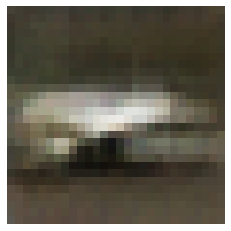

Epoch 9/20... Discriminator Loss: 0.8190... Generator Loss: 1.4776


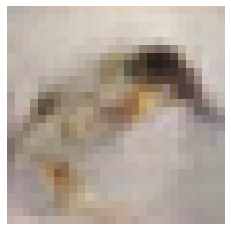

Epoch 9/20... Discriminator Loss: 0.9364... Generator Loss: 1.0388


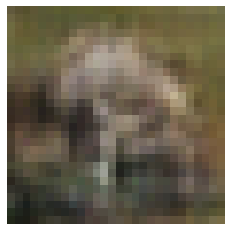

Epoch 9/20... Discriminator Loss: 1.2453... Generator Loss: 0.8195


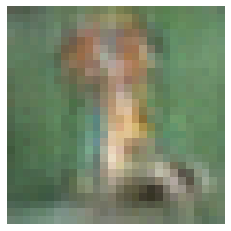

Epoch 9/20... Discriminator Loss: 1.2916... Generator Loss: 0.8101


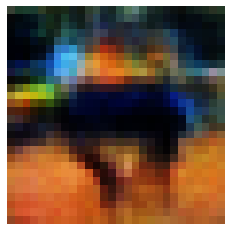

Epoch 9/20... Discriminator Loss: 0.9614... Generator Loss: 1.0170


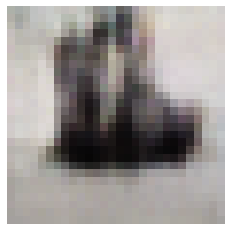

Epoch 9/20... Discriminator Loss: 0.8887... Generator Loss: 1.1129


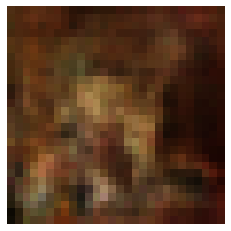

Epoch 10/20... Discriminator Loss: 0.8864... Generator Loss: 1.2787


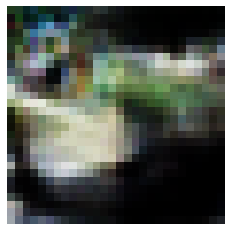

Epoch 10/20... Discriminator Loss: 0.9819... Generator Loss: 0.9250


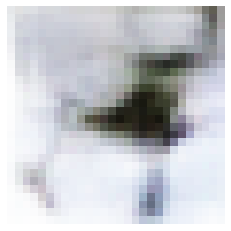

Epoch 10/20... Discriminator Loss: 1.0242... Generator Loss: 0.9461


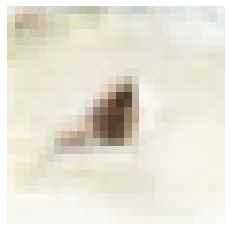

Epoch 10/20... Discriminator Loss: 0.7704... Generator Loss: 1.1899


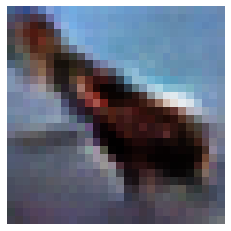

Epoch 10/20... Discriminator Loss: 0.7579... Generator Loss: 1.3371


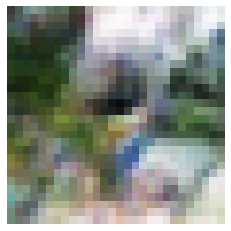

Epoch 10/20... Discriminator Loss: 1.0330... Generator Loss: 0.8839


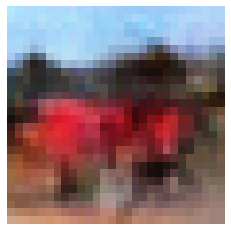

Epoch 10/20... Discriminator Loss: 1.0143... Generator Loss: 1.0292


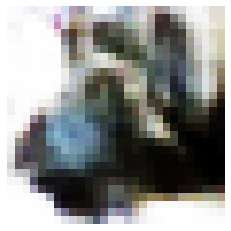

Epoch 10/20... Discriminator Loss: 0.9999... Generator Loss: 0.9644


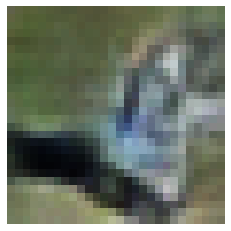

Epoch 11/20... Discriminator Loss: 0.9697... Generator Loss: 1.0255


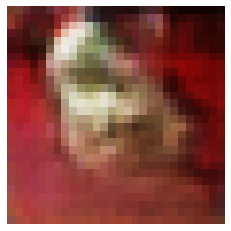

Epoch 11/20... Discriminator Loss: 1.1812... Generator Loss: 0.7413


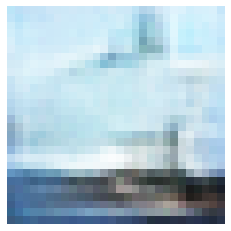

Epoch 11/20... Discriminator Loss: 1.1062... Generator Loss: 0.8615


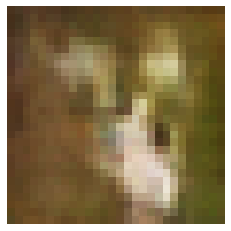

Epoch 11/20... Discriminator Loss: 0.6965... Generator Loss: 1.3245


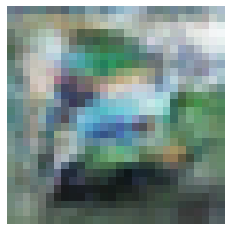

Epoch 11/20... Discriminator Loss: 0.8133... Generator Loss: 1.1095


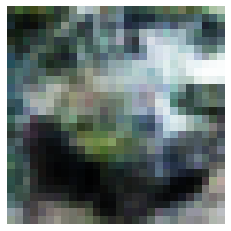

Epoch 11/20... Discriminator Loss: 1.0263... Generator Loss: 1.0257


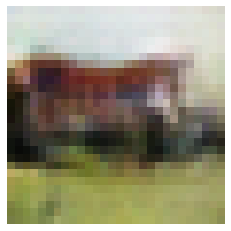

Epoch 11/20... Discriminator Loss: 0.7962... Generator Loss: 1.4736


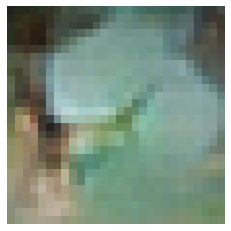

Epoch 12/20... Discriminator Loss: 1.3268... Generator Loss: 0.6448


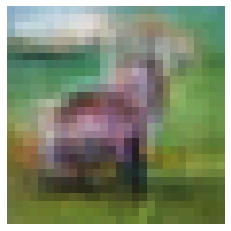

Epoch 12/20... Discriminator Loss: 0.8840... Generator Loss: 1.2387


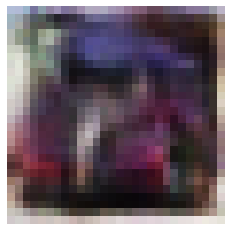

Epoch 12/20... Discriminator Loss: 0.6800... Generator Loss: 1.8246


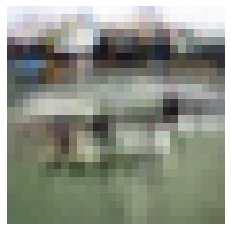

Epoch 12/20... Discriminator Loss: 0.9270... Generator Loss: 1.1329


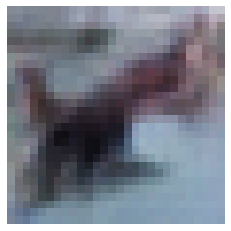

Epoch 12/20... Discriminator Loss: 0.7852... Generator Loss: 1.1569


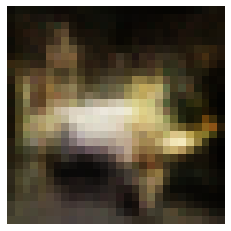

Epoch 12/20... Discriminator Loss: 0.8245... Generator Loss: 1.3702


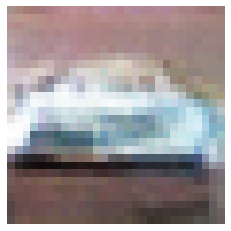

Epoch 12/20... Discriminator Loss: 1.3098... Generator Loss: 0.7067


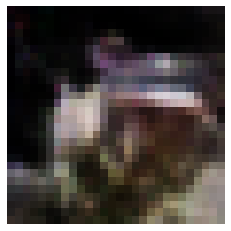

Epoch 12/20... Discriminator Loss: 1.2435... Generator Loss: 0.8667


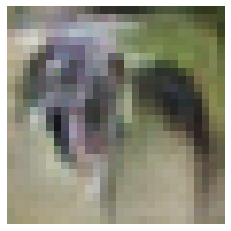

Epoch 13/20... Discriminator Loss: 1.1222... Generator Loss: 0.9728


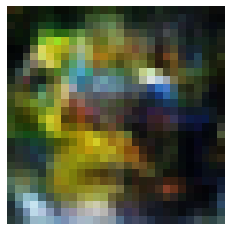

Epoch 13/20... Discriminator Loss: 0.8289... Generator Loss: 1.0716


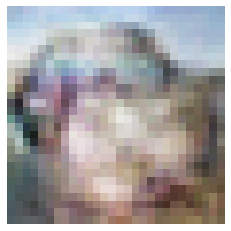

Epoch 13/20... Discriminator Loss: 0.7316... Generator Loss: 1.3287


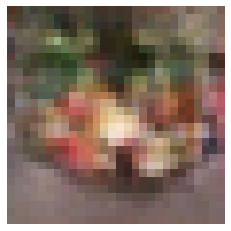

Epoch 13/20... Discriminator Loss: 0.9898... Generator Loss: 0.9329


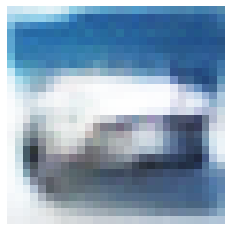

Epoch 13/20... Discriminator Loss: 1.1505... Generator Loss: 0.8468


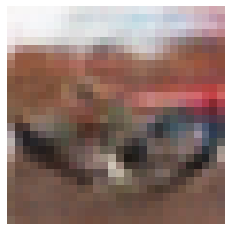

Epoch 13/20... Discriminator Loss: 0.6243... Generator Loss: 1.5712


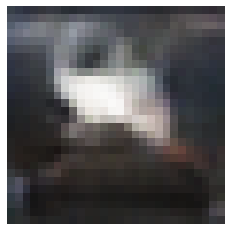

Epoch 13/20... Discriminator Loss: 0.7584... Generator Loss: 1.2612


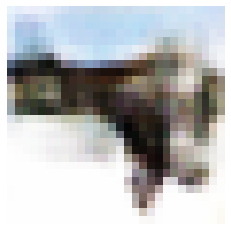

Epoch 13/20... Discriminator Loss: 0.6769... Generator Loss: 1.4866


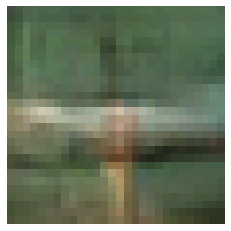

Epoch 14/20... Discriminator Loss: 0.7514... Generator Loss: 1.3475


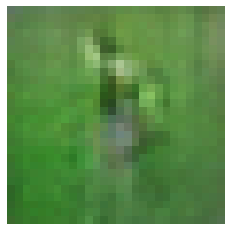

Epoch 14/20... Discriminator Loss: 1.0277... Generator Loss: 0.9663


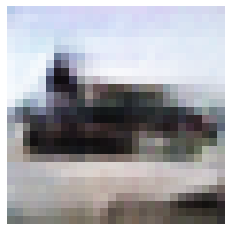

Epoch 14/20... Discriminator Loss: 1.2980... Generator Loss: 0.8012


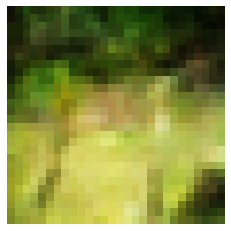

Epoch 14/20... Discriminator Loss: 1.0184... Generator Loss: 1.1817


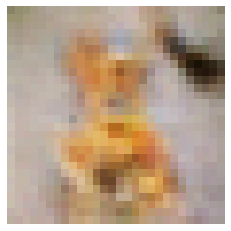

Epoch 14/20... Discriminator Loss: 0.8937... Generator Loss: 1.0559


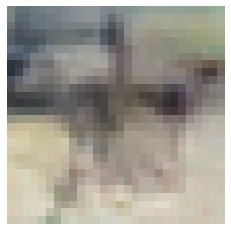

Epoch 14/20... Discriminator Loss: 1.0900... Generator Loss: 0.9910


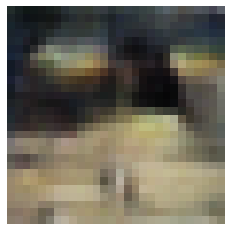

Epoch 14/20... Discriminator Loss: 1.1271... Generator Loss: 0.8593


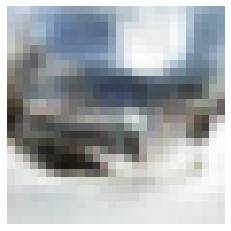

Epoch 14/20... Discriminator Loss: 0.8118... Generator Loss: 1.2860


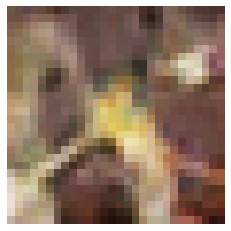

Epoch 15/20... Discriminator Loss: 1.1430... Generator Loss: 0.8011


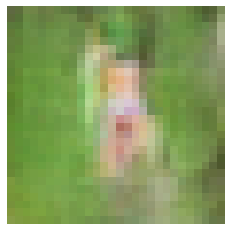

Epoch 15/20... Discriminator Loss: 1.0059... Generator Loss: 0.9317


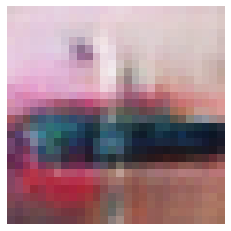

Epoch 15/20... Discriminator Loss: 0.7787... Generator Loss: 1.2075


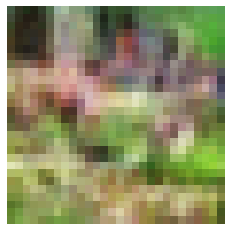

Epoch 15/20... Discriminator Loss: 1.1590... Generator Loss: 0.8508


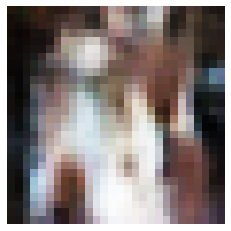

Epoch 15/20... Discriminator Loss: 0.7408... Generator Loss: 1.3181


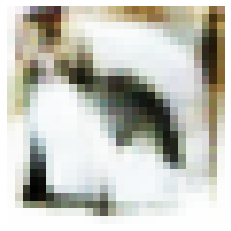

Epoch 15/20... Discriminator Loss: 0.6152... Generator Loss: 1.5430


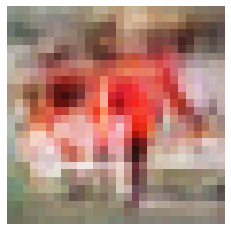

Epoch 15/20... Discriminator Loss: 1.1327... Generator Loss: 1.1590


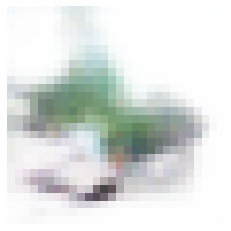

Epoch 15/20... Discriminator Loss: 0.7745... Generator Loss: 1.2315


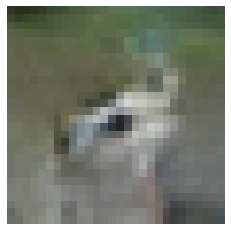

Epoch 16/20... Discriminator Loss: 0.9069... Generator Loss: 1.1760


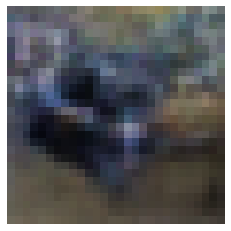

Epoch 16/20... Discriminator Loss: 0.9854... Generator Loss: 0.9187


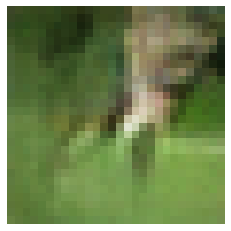

Epoch 16/20... Discriminator Loss: 1.0555... Generator Loss: 0.9038


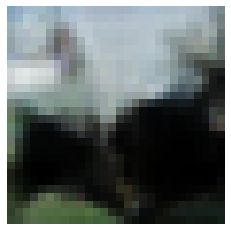

Epoch 16/20... Discriminator Loss: 0.9702... Generator Loss: 0.9015


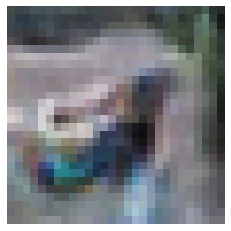

Epoch 16/20... Discriminator Loss: 0.8450... Generator Loss: 1.1364


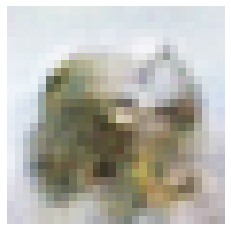

Epoch 16/20... Discriminator Loss: 0.6929... Generator Loss: 1.4883


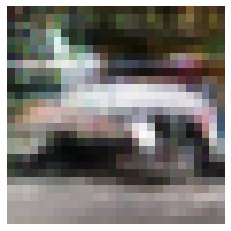

Epoch 16/20... Discriminator Loss: 0.8001... Generator Loss: 1.4758


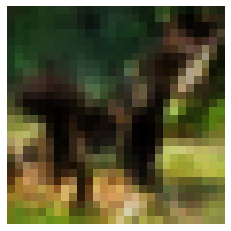

Epoch 16/20... Discriminator Loss: 0.7853... Generator Loss: 1.2107


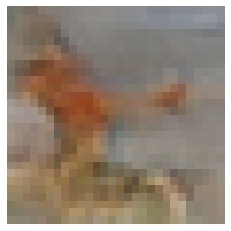

Epoch 17/20... Discriminator Loss: 0.8614... Generator Loss: 1.0796


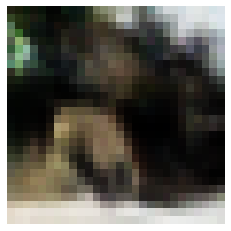

Epoch 17/20... Discriminator Loss: 1.2317... Generator Loss: 0.7414


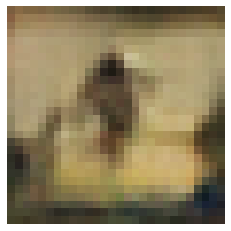

Epoch 17/20... Discriminator Loss: 1.0287... Generator Loss: 0.9504


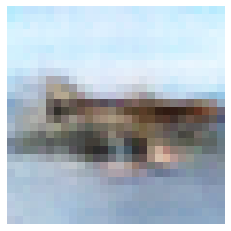

Epoch 17/20... Discriminator Loss: 0.9695... Generator Loss: 0.9919


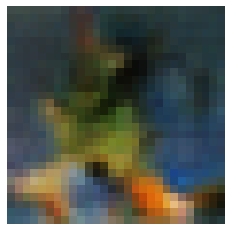

Epoch 17/20... Discriminator Loss: 0.9042... Generator Loss: 1.0343


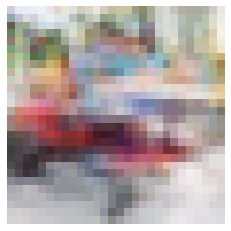

Epoch 17/20... Discriminator Loss: 1.1047... Generator Loss: 0.7763


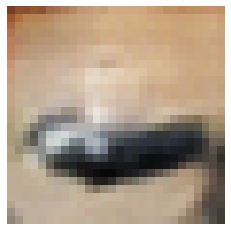

Epoch 17/20... Discriminator Loss: 0.7158... Generator Loss: 1.3865


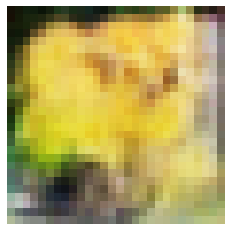

Epoch 18/20... Discriminator Loss: 0.8266... Generator Loss: 1.3122


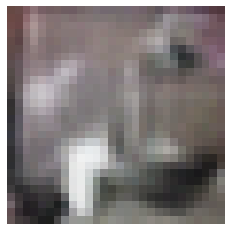

Epoch 18/20... Discriminator Loss: 0.9778... Generator Loss: 1.0162


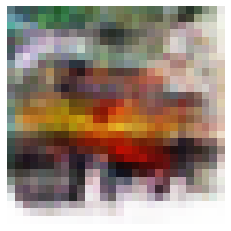

Epoch 18/20... Discriminator Loss: 1.0521... Generator Loss: 1.2620


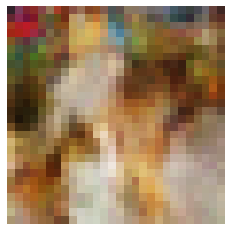

Epoch 18/20... Discriminator Loss: 1.1352... Generator Loss: 0.9612


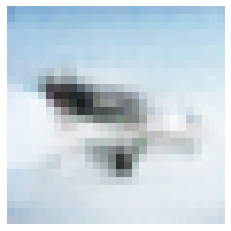

Epoch 18/20... Discriminator Loss: 0.7015... Generator Loss: 1.5311


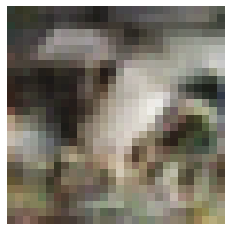

Epoch 18/20... Discriminator Loss: 2.8124... Generator Loss: 2.6410


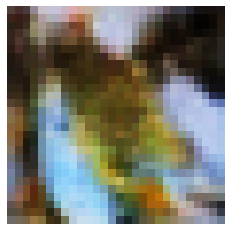

Epoch 18/20... Discriminator Loss: 0.9414... Generator Loss: 1.0554


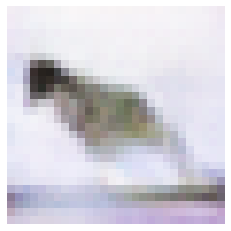

Epoch 18/20... Discriminator Loss: 0.9206... Generator Loss: 1.1326


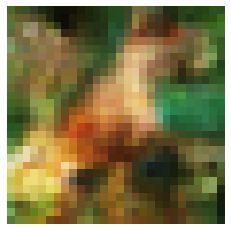

Epoch 19/20... Discriminator Loss: 0.9957... Generator Loss: 1.1682


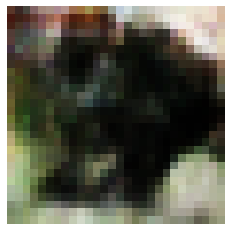

Epoch 19/20... Discriminator Loss: 0.9318... Generator Loss: 1.0307


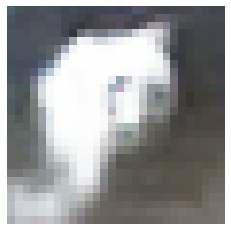

Epoch 19/20... Discriminator Loss: 1.1838... Generator Loss: 0.8593


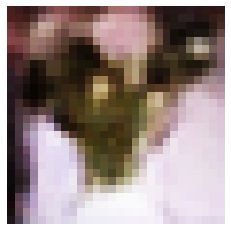

Epoch 19/20... Discriminator Loss: 0.6809... Generator Loss: 1.3917


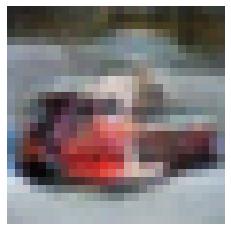

Epoch 19/20... Discriminator Loss: 0.8701... Generator Loss: 1.1206


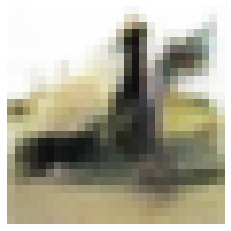

Epoch 19/20... Discriminator Loss: 0.8994... Generator Loss: 1.2938


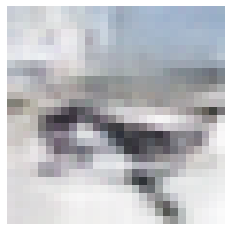

Epoch 19/20... Discriminator Loss: 1.0677... Generator Loss: 0.8184


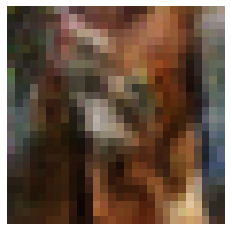

Epoch 19/20... Discriminator Loss: 0.9831... Generator Loss: 1.0449


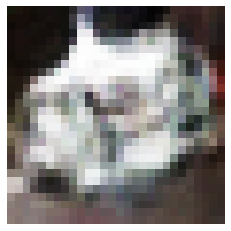

Epoch 20/20... Discriminator Loss: 0.8290... Generator Loss: 1.1131


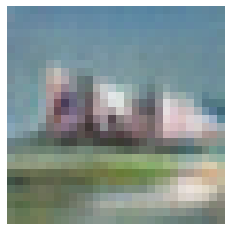

Epoch 20/20... Discriminator Loss: 0.7550... Generator Loss: 1.3692


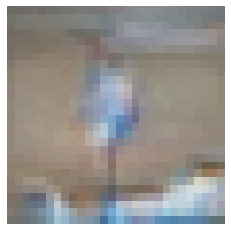

Epoch 20/20... Discriminator Loss: 0.9255... Generator Loss: 0.9629


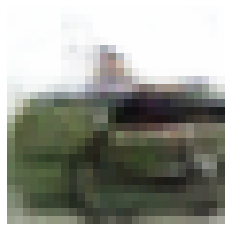

Epoch 20/20... Discriminator Loss: 0.8855... Generator Loss: 1.2640


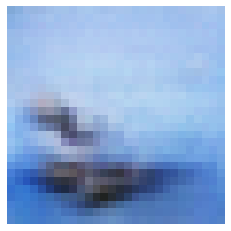

Epoch 20/20... Discriminator Loss: 1.0705... Generator Loss: 0.8941


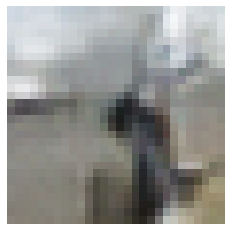

Epoch 20/20... Discriminator Loss: 0.8877... Generator Loss: 1.0341


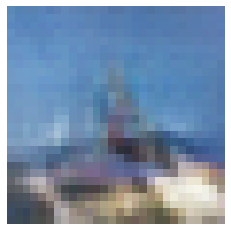

Epoch 20/20... Discriminator Loss: 1.1132... Generator Loss: 0.9926


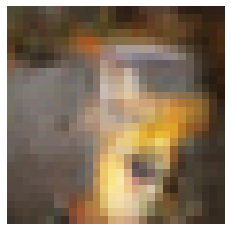

Epoch 20/20... Discriminator Loss: 0.6230... Generator Loss: 1.5603


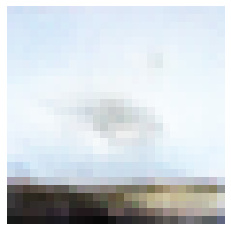

In [12]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
epochs = 20

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, shape)

## As can be seen, the generated images don't really seem to belong to any particular category in the CIFAR-10 dataset. This might be due to the fact that this dataset is just too diverse for the generator to learn it's distribution. Also the images are RGB.  But we can appreciate that the outputs are way better than random noise (which is heartbreaking after lots of effort), and even  look like low resolution Pokémons. :P